# Transformer

- Transformer는 **Self-Attention** 메커니즘을 활용해 입력 시퀀스 내 요소들 간의 관계를 동시 처리하는 딥러닝 모델

- 인코더-디코더 구조를 갖고 있으며, 각각 다층의 attention 및 feedforward 레이어로 구성

- 앞 단원에서는 순환 신경망을 거친 encoder output과 마찬가지로 순환 신경망을 거쳐 나온 디코더 아웃풋 간의 attention 구조를 살펴보았다.

- Transformer는 순환 신경망 과정을 생략하고 대신 self-attention 구조를 이용.

- 순차적인 처리 없이도 병렬 연산이 가능해, 번역·요약·질문응답 등 다양한 자연어 처리 작업에서 뛰어난 성능을 보임

- 과목 특성상 자연어 처리작업을 하기는 어려우므로 이 단원에서는 Transformer의 구조에 대해 간략히 알아본다.

## Positional encoding

Transformer 아키텍처는 기본적으로 순서에 의존하지 않는 구조인 self-attention 메커니즘을 기반으로 한다.   
    
추후 알아볼 self-attention은 입력 시퀀스를 처리할 때 각 위치의 값들이 서로 독립적으로 처리되므로, 순서 정보가 내재되어 있지 않다. 
- RNN과 같은 전통적인 시퀀스 모델들은 자연스럽게 순서를 처리하지만, Transformer는 병렬 처리가 가능하도록 설계되어 순서 정보가 내재되어 있지 않다.

따라서, 시퀀스의 순서 정보를 모델에 제공하기 위해 positional encoding을 도입하여, 입력 시퀀스의 각 위치에 대한 순서 정보를 학습할 수 있게 하였다.

### Positional Encoding 방식

Transformer에서 사용되는 대표적인 positional encoding 방식은 사인과 코사인 함수를 사용한다. 

각 차원에 대해 다른 주기를 가지는 사인과 코사인 값을 사용하여 각 위치의 인코딩을 생성한다.

이러한 방식은 시퀀스의 길이에 관계없이 위치 정보를 제공할 수 있고, 모델이 이를 통해 위치 정보를 학습할 수 있도록 돕는다.

Positional enconding에 사용되는 수식은 다음과 같다.

$$\textrm{PE}{(p, 2i)} = \sin\left(\frac{p}{N^{2i/d}} \right), \quad \textrm{PE}{(p, 2i+1)} = \cos\left(\frac{p}{N^{2i/d}}\right)$$

- $p$ : 시간축에 대한 인덱스
- $2i, 2i+1$ : 입력 시퀀스의 차원에 대한 인덱스, 각, 짝수와 홀수 인덱스를 의미
- $N$ : 큰 양수
- $d$ : 입력 시퀀스의 차원

`numpy`를 이용해 간단히 표현하면 다음과 같다.

In [4]:
import numpy as np
import math

# Define sequence length and model dimension
timestep = 6
dim = 4

pe = np.zeros((timestep, dim))
    
# Calculate the position indices for the sequence
position = np.arange(0, timestep)[:, np.newaxis]

N = 10000.0
# Calculate the dimension indices
div_term = 1 / np.power(N, np.arange(0, dim, 2) / dim)

# Apply the sin function to even indices and cos function to odd indices
pe[:, 0::2] = np.sin(position * div_term)  # Apply sin to even indices
pe[:, 1::2] = np.cos(position * div_term)  # Apply cos to odd indices

# Print the positional encoding matrix
print(pe)

[[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.00999983  0.99995   ]
 [ 0.90929743 -0.41614684  0.01999867  0.99980001]
 [ 0.14112001 -0.9899925   0.0299955   0.99955003]
 [-0.7568025  -0.65364362  0.03998933  0.99920011]
 [-0.95892427  0.28366219  0.04997917  0.99875026]]


위에서 출력된 행렬의 행은 시간축이고, 열은 입력 시퀀스의 차원을 나타낸다.

같은 거리에 있는 positional encoding 벡터들을 내적하였을 때, 동일한 값을 가짐을 확인해 보자.

In [2]:
pe[0, :] @ pe[1, :], pe[1, :] @ pe[2, :], pe[2, :] @ pe[3, :], pe[3, :] @ pe[4, :], pe[4, :] @ pe[5, :]

(1.540252306284805,
 1.5402523062848048,
 1.540252306284805,
 1.540252306284805,
 1.540252306284805)

In [3]:
pe[0, :] @ pe[2, :], pe[1, :] @ pe[3, :], pe[2, :] @ pe[4, :], pe[3, :] @ pe[5, :]

(0.5836531701194354,
 0.5836531701194354,
 0.5836531701194354,
 0.5836531701194355)

Positional encoding을 담당하는 keras layer를 클래스로 정의하여 보자.

- `class PositionalEncoding(layers.Layer):` TensorFlow/Keras에서 사용자 정의 레이어를 만들기 위한 정의

  - `layers.Layer`를 상속했기 때문에 Keras의 커스텀 레이어가 됨
 
  - 이 레이어는 `__init__`, `call`, 등의 메서드를 통해 정의된 사용자 정의 동작을 수행할 수 있음

- 편의상, 이 코드는 짝수의 `dim`에 대해서만 작동하도록 만들었음

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class PositionalEncoding(layers.Layer):
    def __init__(self, max_len, dim):
        super(PositionalEncoding, self).__init__()
        pos_encoding = np.zeros((max_len, dim))
        positions = np.arange(0, max_len)[:, np.newaxis]

        N = 10000.0
        div_term =  1 / np.power(N, np.arange(0, dim, 2) / dim)
        
        pos_encoding[:, 0::2] = np.sin(positions * div_term)
        pos_encoding[:, 1::2] = np.cos(positions * div_term)
        
        pos_encoding = pos_encoding[np.newaxis, ...]
        self.pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

잘 작동하는지 확인해 보자.

- shape이 `(1, timestep, dim)`인 제로 시퀀스 입력에 대해 위치 정보를 부여하는 positional encoding이 잘 작동하는지 테스트

- 아래 출력 결과를 보면, 출력이 timestep마다 다르며, 이는 positional encoding이 위치 정보를 명시적으로 부여했다는 의미 

In [3]:
PositionalEncoding(timestep, dim)(np.zeros((1, timestep, dim)))

<tf.Tensor: shape=(1, 6, 4), dtype=float32, numpy=
array([[[ 0.        ,  1.        ,  0.        ,  1.        ],
        [ 0.84147096,  0.5403023 ,  0.00999983,  0.99995   ],
        [ 0.9092974 , -0.41614684,  0.01999867,  0.9998    ],
        [ 0.14112   , -0.9899925 ,  0.0299955 ,  0.99955004],
        [-0.7568025 , -0.6536436 ,  0.03998933,  0.9992001 ],
        [-0.9589243 ,  0.2836622 ,  0.04997917,  0.99875027]]],
      dtype=float32)>

## Scaled dot-product attention

Attention은 이전 단원에서 살펴본 것처럼 query, key, value들의 dot product들로 계산한다.

Attention의 목적은 query와 key의 유사성을 dot-product로 계산하여, 이를 기반으로 value에 가중치를 부여하는 것이다.

* **Query (Q)**: 현재 우리가 “관심 있는 항목”에 대한 표현. 디코더의 현재 시점 상태 등이 사용됨.
  
* **Key (K)**: 인코더의 각 위치에 대한 설명. 디코더가 어떤 인코더 위치에 주목할지 판단할 기준.
  
* **Value (V)**: 실제로 정보를 얻고자 하는 대상. 보통 Key와 동일한 위치에서 생성된 벡터.
  

### 가중치 행렬 연산

Transformer의 Attention 메커니즘에서 Query, Key, Value는 각각 입력 시퀀스 `X_q`, `X_k`, `X_v`에 가중치 행렬 `W_q`, `W_k`, `W_v`를 곱하여 생성된다.

- 만약 쿼리 입력 시퀀스 `X_q`와 키 입력 시퀀스 `X_k`가 같다면 self-attention이라고 부른다. 

- 쿼리 입력 시퀀스 `X_q`와 값 입력 시퀀스 `X_v`는 같을 수도 있고 다를 수도 있다.

쿼리 입력 시퀀스의 차원을 `d_model_q`, 키 입력 시퀀스의 차원을 `d_model_q`이라고 하자. 

- 쿼리 입력 시퀀스의 shape : `(batch_size, seq_len_q, d_model_q)`

- 키 입력 시퀀스의 shape : `(batch_size, seq_len_k, d_model_k)`

가중치 행렬들의 shape은 다음과 같다.

* `W_q`: `(d_model_q, key_dim)`  
* `W_k`: `(d_model_k, key_dim)`  
* `W_v`: `(d_model_q, val_dim)`  

입력 시퀀스를 `X`들이라고 할 때, query, key, value의 계산 과정과 shape들은 다음과 같다.

* `Q = X_q @ W_q`    # shape: `(batch_size, seq_len_q, key_dim)`
* `K = X_k @ W_k`    # shape: `(batch_size, seq_len_k, key_dim)`
* `V = X_v @ W_v`    # shape: `(batch_size, seq_len_k, val_dim)`

### 차원 관계 정리

| 입력 `X`          | `W`                                | 쿼리, 키, 값 |
| ------------- | --------------------------------- |-----------------|
| `X_q` : `(batch_size, seq_len_q, d_model_q)` | `W_q` : `(d_model_q, key_dim)` | `Q` :  `(batch_size, seq_len_q, key_dim)`
| `X_k` : `(batch_size, seq_len_k, d_model_k)` | `W_k`: `(d_model_k, key_dim)` | `K` : `(batch_size, seq_len_k, key_dim)`
| `X_v` : `(batch_size, seq_len_k, d_model_v)` | `W_v`: `(d_model_q, val_dim)` | `V` : `(batch_size, seq_len_k, val_dim)`


* `key_dim == query_dim`이어야 $\mathrm{Q} \, \mathrm{K}^{\top}$가 정의됨.
  
* `seq_len_k`와 `seq_len_q`는 시퀀스의 길이이며 같을 수도 있고, 다를 수도 있음. (ex: 인코더는 10, 디코더는 5)
  
* key의 dimension(`key_dim`)과 value의 dimension(`val_dim`)은 같을 수도 있고, 다를 수도 있음

* `d_model_q`, `d_model_k`, `d_model_v` 또한 모두 같을 수도 있고 다를 수도 있음

### Attention 연산 요약

1. 유사도 계산 (Dot Product)
   - $\text{scores} = \mathrm{Q} \, \mathrm{K}^{\top}, \quad$ shape:  `(batch_size, seq_len_q, seq_len_k)` <br><br>

2. Scaling (정규화)
   - $\text{scaled\_scores} = \frac{\mathrm{Q} \, \mathrm{K}^{\top}}{\sqrt{\text{key\_dim}}}$ <br><br>

3. Softmax로 확률 분포화 (각 query 시점 마다)
   - $\text{Attention Weights} = \text{softmax}(\text{scaled\_scores})$ <br><br>

4. Weighted sum of values 
   - $\text{context} = \text{Attention Weights} \cdot \mathrm{V}, \quad $  shape: `(batch_size, seq_len_q, val_dim)`

#### Scaling을 하는 이유

- Dot product attention은 종종 `key_dim`(depth)의 제곱근으로 조정되는데, 이는 model의 depth가 클 경우 dot product의 값이 매우 커질 수 있기 때문이다. 

- 이렇게 되면 softmax function이 매우 좁은 범위에서 작동하게 되어, gradient가 작은 부분에서 매우 급격한 변화가 발생하는 'sharp' softmax가 생성될 수 있다.

- 이러한 문제를 피하기 위해 depth의 제곱근으로 dot product 값을 나누어 조정한다.

아래 예제에서 `Q`, `K`, `V`는 `W`들과의 연산을 통해 이미 만들어진 query, key, value의 계산 결과라고 가정하자.

In [109]:
np.set_printoptions(suppress=True)

Q = np.array([[0, 0, 10],
                   [0, 10, 0],
                   [10, 10, 0]])  # (seq_len_q, key_dim) = (3, 3)

K = np.array([[10, 0, 0],
                   [0, 10, 0],
                   [0, 0, 10],
                   [0, 0, 10]])  # (seq_len_k, key_dim) = (4, 3)

V = np.array([[1, 0],
                   [10, 0],
                   [100, 5],
                   [1000, 6]])  # (seq_len_k, val_dim) = (4, 2)

key_dim = np.shape(K)[-1] # 3
query_dim = np.shape(Q)[-1] # 3

seq_len_q = np.shape(Q)[-2]  # 3
seq_len_k = np.shape(K)[-2]  # 4
seq_len_v = np.shape(V)[-2]  # 4


matmul_qk = Q @ K.T   # attention score, (seq_len_q, seq_len_k) = (3, 4)

scaled_attention_logits = matmul_qk / math.sqrt(key_dim) # scaled attention score

attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (seq_len_q, seq_len_k) = (3, 4)

output = tf.matmul(attention_weights, V)  # (seq_len_q, depth_v) = (3, 2)

아래 코드에서 `attention_weights`을 프린트한 결과를 보면, 주어진 query가 value의 어디에 집중해야 하는지 설명한다.

- Query `temp_q`의 첫번째 값은 value의 세번째와 네번째 값에 집중해야 한다.
- Query `temp_q`의 두번째 값은 value의 두번째 값에 집중해야 한다.
- Query `temp_q`의 세번째 값은 value의 첫번째와 두번째 값에 집중해야 한다.

In [110]:
print("Attention weight : \n", attention_weights)

Attention weight : 
 tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float64)


Attention weight를 value에 적용된 결과는 다음과 같다.

- Query `Q`의 첫번째 값의 의미는 `[550.    5.5]`으로 해석됨.
- Query `Q`의 두번째 값의 의미는 `[ 10.    0. ]`으로 해석됨.
- Query `Q`의 세번째 값의 의미는 `[  5.5   0. ]`으로 해석됨.

Output의 sequence 길이는 `seq_len_q`와 같고, dimension은 `dim_v`와 같다.

In [111]:
print("Output  : \n", output)

Output  : 
 tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float64)


## Multi-head attention

**Multi-Head Attention**에서는 

* 쿼리 Q, 키 K, 값 V의 차원을 `num_heads`개의 subspace로 분할하고, 각 head마다 독립적인 attention을 수행한 뒤,

* 그 결과들을 **결합(concatenate)** 후 다시 선형 변환하여 하나의 출력으로 만든다.

각, head별 쿼리와 키의 차원을 `key_dim`이라 하자.

그러면 `key_dim * num_head`는 `Q` 전체의 feature 차원의 개수가 된다. 

예를 들어, `Q` 전체의 feature 차원이 `512`, `num_heads = 8`이면, 각 head에서 키와 쿼리는 `512 / 8 = 64`차원짜리 feature를 갖게 되는 셈.

In [123]:
Q = np.array([[0, 0, 10, 10],
                   [0, 10, 0, 0],
                   [10, 10, 0, 0]])  # (4, 3)

K = np.array([[10, 0, 0, 0],
                   [0, 10, 0, 10],
                   [0, 0, 10, 0],
                   [0, 0, 10, 0]])  # (4, 4)

V = np.array([[1, 0],
                   [10, 0],
                   [100, 5],
                   [1000, 6]])  # (4, 2)


total_key_dim = np.shape(K)[-1] # 4
total_v_dim = np.shape(V)[-1] # 2
num_heads = 2

key_dim = total_key_dim// num_heads
v_dim = total_v_dim // num_heads

Q = np.reshape(Q, (-1, num_heads, key_dim)) # shape = (seq_len, num_heads, key_dim)
Q = Q.transpose((1, 0, 2)) # shape = (num_heads, seq_len, key_dim)

K = np.reshape(K, (-1, num_heads, key_dim))
K = K.transpose((1, 0, 2))

V = np.reshape(V, (-1, num_heads, v_dim))
V = V.transpose((1, 0, 2))

matmul_qk = np.matmul(Q, K.transpose((0, 2, 1)))   # attention score

scaled_attention_logits = matmul_qk / math.sqrt(key_dim) # scaled attention score, (..., seq_len_q, seq_len_k)

attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

print(attention_weights)  # num_heads 개의 attention_weights들

tf.Tensor(
[[[0.25       0.25       0.25       0.25      ]
  [0.         1.         0.         0.        ]
  [0.5        0.5        0.         0.        ]]

 [[0.         0.33333333 0.33333333 0.33333333]
  [0.25       0.25       0.25       0.25      ]
  [0.25       0.25       0.25       0.25      ]]], shape=(2, 3, 4), dtype=float64)


최종 output, 즉, 쿼리 별 value 결과값은 이전과 마찬가지로 `(seq_len_q, dim_v)`의 shape을 가진다.

In [124]:
output = tf.matmul(attention_weights, V)  
print(output)

tf.Tensor(
[[[277.75      ]
  [ 10.        ]
  [  5.5       ]]

 [[  3.66666667]
  [  2.75      ]
  [  2.75      ]]], shape=(2, 3, 1), dtype=float64)


In [125]:
output = np.transpose(output, (1, 0, 2))  # (seq_len_q, num_heads, v_dim)
output = np.reshape(output, (-1, total_v_dim))  # (seq_len_q, total_v_dim)

print(output)

[[277.75         3.66666667]
 [ 10.           2.75      ]
 [  5.5          2.75      ]]


## Multi-Head Self Attention

Transformer의 Multi-Head Self Attention의 작동 방식은 다음과 같다.

- 이전에 공부한 어텐션 메커니즘에서는 query가 디코더에서 제공되고, key와 value는 인코더에서 제공된다. 이는 디코더가 인코더의 출력과 상호작용하여 관련 정보를 추출하는 방식.

- **셀프** 어텐션에서는 query, key, value를 모두 동일한 입력 시퀀스에서 생성한다. 즉, 인코더 입력 데이터 자체에서 query, key, value를 추출함.

- 이 방식은 입력 시퀀스의 각 요소가 시퀀스 내의 다른 모든 요소와 상호작용하여, 자신의 문맥(context)을 이해하도록 도와준다.

- **Multi-Head** attention은 이러한 셀프 어텐션을 여러 헤드로 병렬 처리하여, 서로 다른 서브스페이스의 정보를 학습할 수 있게 한다. 각 헤드는 입력 데이터의 다른 부분에 초점을 맞추어 보다 풍부한 표현을 학습하는 효과가 있다.

- 이를 통해 모델은 시퀀스 내의 긴 의존성을 효과적으로 캡처할 수 있으며, 자연어 처리와 같은 분야에서 문맥을 이해하는 데 매우 유용하다.

- Self-attentions에서는 자연스럽게 `X_q = X_k`, `Q = K`이 된다. 단, value는 key와 다르게 지정 가능

케라스에서는 [`tensorflow.keras.MultiHeadAttention`](https://keras.io/api/layers/attention_layers/multi_head_attention/)를 이용하여 구현할 수 있다.

### MultiHeadAttention 구조

`MultiHeadAttention`에서의 작업 흐름은 다음과 같다.

```
Input Tensor → [Dense Layer for Query (W_q)] → Queries (Q)
Input Tensor → [Dense Layer for Key (W_k)]   → Keys (K)
Input Tensor → [Dense Layer for Value (W_v)] → Values (V)

[Split into h heads]  (Q → Q₁...Q_h,  K → K₁...K_h,  V → V₁...V_h)

[For each attention head]                                                                      
     [Scaled Dot Product Attention] (Q_i · K_i^T / sqrt(depth)) → Attention Scores
        → [Softmax] → Attention Weights
        → [Dot Product] (Attention Weights, V_i)
        → Attention Outputs (for each head)
               ↓                       
[Concatenate Heads] → Combined all Head Outputs → [Dense Layer] →  Output

```

Self multi head attention 결과는 입력 시퀀스의 복잡한 관계를 학습하여, 시퀀스 내의 문맥 정보를 풍부하게 표현한 결과라고 볼 수 있다.

`MultiHeadAttention`의 주요 인자는 다음과 같다.

- `num_heads` : 병렬 처리되는 head들의 수.  head는 input dimension을 나누어서 사용하기 때문에, 일반적으로 input dimension이 head의 수로 나누어떨어지도록 설정된다.
  
- `key_dim` : 각 head 별 query 및 key의 벡터 차원, 전체 query 및 key 벡터는 `num_heads * key_dim`의 차원을 가짐

`MultiHeadAttention`의 call argument로서 `query`, `key`, `value`가 존재하는데, 이들은 각각 Q, K, V를 생성하는데 사용되는 입력 벡터 역할을 한다고 생각하면 된다.

- 즉, $W$들이 곱해지기 전의 값.

- 마지막 Dense layer는 Concatenate된 head의 결과를 모델의 기대하는 차원으로 투영하는 역할. Timedistrbuted로 처리 됨.

  - `output_shape`을 따로 지정할 수도 있고, default로 `output_shape = None`일 경우 (쿼리) 입력 차원과 동일

### `MultiHeadAttention` 파라미터 분석

간단하게 `key_dim = value_dim`이고, `output_shape`을 따로 설정하지 않은 상황, 즉, `output_dim = input_dim`에서 살펴보자.  

- Q, K, V의 weight matrix들

  - Q, K, V는 기본적으로 `input_dim` 차원의 벡터를 `num_heads * key_dim` 차원으로 보내는 역할
  
  - 각각 `(input_dim, num_heads * key_dim)` 크기의 행렬, 즉 각각 `input_dim * num_heads * key_dim`의 파라미터 수를 가짐.

- Bias term for Q, K, V: 각각 `num_heads * key_dim` 개수의 bias term이 있음

- Output projection dense layer 가중치 :

  - Head output을 모두 concat한 후, 최종 출력 차원으로 다시 투영하는 dense layer : `(num_heads * value_dim) → output_dim`
  
    - 단, 아래 예제에서는 `key_dim = value_dim`을 가정 중  <br><br>
  - W: shape = (`num_heads * key_dim`, `output_dim`), 보통 `output_dim = input_dim`

  - bias : `output_dim`개

In [78]:
# 이 값들을 변경해 가며 테스트해 보자.
input_dim = 24
key_dim = 3
num_heads = 8

encoder_inputs = keras.Input(shape=(timestep, input_dim))
MHA_layer = layers.MultiHeadAttention(key_dim=key_dim, num_heads=num_heads)
x = MHA_layer(encoder_inputs, encoder_inputs) # (query, value). key는 생략, 즉, key=query로 자동 설정
model = keras.Model(encoder_inputs, x)
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 6, 24)]      0           []                               
                                                                                                  
 multi_head_attention_47 (Multi  (None, 6, 24)       2400        ['input_19[0][0]',               
 HeadAttention)                                                   'input_19[0][0]']               
                                                                                                  
Total params: 2,400
Trainable params: 2,400
Non-trainable params: 0
__________________________________________________________________________________________________


In [79]:
# Q, K, V 계산을 위한 W와 bias들 파라미터의 수
3 * (input_dim * num_heads * key_dim + num_heads * key_dim)

1800

In [80]:
# 마지막 dense layer의 파라미터 수. output_dim = input_dim
num_heads * key_dim * input_dim +  input_dim

600

In [81]:
# 총합
3 * (input_dim * num_heads * key_dim + num_heads * key_dim) + num_heads * key_dim * input_dim +  input_dim

2400

물론 `key_dim != value_dim`과 `input_dim != output_dim`인 경우도 파라미터 개수를 계산해 볼 수 있다.

In [2]:
# 이 값들을 변경해 가며 테스트해 보자.
timestep = 6
dim = 4

input_dim = 24
output_shape = 32  # output_dim
key_dim = 3
value_dim = 4
num_heads = 8

encoder_inputs = keras.Input(shape=(timestep, input_dim))
MHA_layer = layers.MultiHeadAttention(key_dim=key_dim, value_dim=value_dim, num_heads=num_heads, output_shape=output_shape)
x = MHA_layer(encoder_inputs, encoder_inputs)  # (query, value). key는 생략, 즉, key=query로 자동 설정
model = keras.Model(encoder_inputs, x)
model.summary()

NameError: name 'keras' is not defined

In [94]:
# 파라미터 수 계산
# W_q, W_k, W_v와 bias들
pa = 2 * (input_dim * num_heads * key_dim + num_heads * key_dim) + (input_dim * num_heads * value_dim + num_heads * value_dim) 
# dense layer
pd = num_heads * value_dim * output_shape +  output_shape
pa + pd

3056

### 간단 예제

입력 시퀀스의 각 time step 벡터를 self-attention으로 처리하여, 그 결과를 그대로 예측하는 간단한 예제를 살펴보자.

In [104]:
# 하이퍼파라미터
seq_len = 5
d_model = 12
num_heads = 4
key_dim = d_model // num_heads
batch_size = 32

# 입력 데이터: 랜덤 시퀀스
X = np.random.randn(1000, seq_len, d_model).astype(np.float32)
Y = X.copy()  # 목표는 그대로 복사

# 모델 구성
inputs = tf.keras.Input(shape=(seq_len, d_model))

# MHA Layer
attention_out = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)

# Optional: Dense layer (identity map)
outputs = layers.Dense(d_model)(attention_out)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 5, 12)]      0           []                               
                                                                                                  
 multi_head_attention_58 (Multi  (None, 5, 12)       624         ['input_25[0][0]',               
 HeadAttention)                                                   'input_25[0][0]']               
                                                                                                  
 dense_2 (Dense)                (None, 5, 12)        156         ['multi_head_attention_58[0][0]']
                                                                                                  
Total params: 780
Trainable params: 780
Non-trainable params: 0
___________________________

In [105]:
# 학습
model.fit(X, Y, epochs=100, batch_size=batch_size, validation_split=0.1)

Epoch 1/50
29/29 [==============================] - 0s 4ms/step - loss: 1.0152 - val_loss: 0.9589
Epoch 2/50
29/29 [==============================] - 0s 2ms/step - loss: 0.9713 - val_loss: 0.9206
Epoch 3/50
29/29 [==============================] - 0s 3ms/step - loss: 0.9252 - val_loss: 0.8689
Epoch 4/50
29/29 [==============================] - 0s 2ms/step - loss: 0.8608 - val_loss: 0.7962
Epoch 5/50
29/29 [==============================] - 0s 2ms/step - loss: 0.7787 - val_loss: 0.7129
Epoch 6/50
29/29 [==============================] - 0s 2ms/step - loss: 0.6942 - val_loss: 0.6332
Epoch 7/50
29/29 [==============================] - 0s 2ms/step - loss: 0.6164 - val_loss: 0.5577
Epoch 8/50
29/29 [==============================] - 0s 2ms/step - loss: 0.5436 - val_loss: 0.4883
Epoch 9/50
29/29 [==============================] - 0s 2ms/step - loss: 0.4811 - val_loss: 0.4331
Epoch 10/50
29/29 [==============================] - 0s 2ms/step - loss: 0.4287 - val_loss: 0.3858
Epoch 11/50
29/29 [

In [107]:
test_input = np.random.randn(1, seq_len, d_model).astype(np.float32)
pred = model.predict(test_input)

print("Input:")
print(np.round(test_input[0], 2))

print("Prediction:")
print(np.round(pred[0], 2))

1/1 [==============================] - 0s 13ms/step
Input:
[[ 0.91  0.24  0.86 -0.19  0.68 -1.18  1.04  0.91  1.53 -1.74 -1.01  1.02]
 [ 0.66  0.68 -1.55 -1.5  -1.19  1.11  1.51 -0.91  0.5   0.7   0.69 -0.53]
 [-1.44  0.87 -0.28  0.02 -1.45  0.9  -0.04  0.54 -0.25  0.85  0.4  -1.49]
 [ 0.46  0.59  0.55  1.17 -1.2  -0.3  -1.07  2.08  0.42 -0.79 -0.45  0.51]
 [-0.15 -1.64 -0.12 -0.34 -0.86 -1.34  0.64  1.53 -0.92  0.39 -0.64  0.44]]
Prediction:
[[ 1.29  0.38  0.64 -0.15  0.58 -0.96  1.01  1.02  1.47 -1.43 -1.    0.49]
 [ 0.38  0.58 -1.34 -1.4  -1.25  0.77  1.28 -0.72  0.4   0.54  0.45 -0.56]
 [-1.48  0.43 -0.72 -0.06 -1.76  0.77  0.24  0.25 -0.76  0.41  0.17 -1.25]
 [ 0.31  0.65  0.27  0.91 -1.25 -0.37 -0.8   2.07  0.39 -0.48  0.06  0.44]
 [-0.03 -1.08 -0.   -0.08 -1.08 -1.5   0.3   1.8  -0.38  0.61 -0.05  0.52]]


## 인코더

인코더 모델을 구성하는 함수를 정의하자. 

인코더 모델은 self-attetion 부분과 feed-forward 부분으로 구성된다.

- 앞에서 공부한 인코더-디코더 모델에서 순환 신경망 대신 self-attention이 있는 형태

Feed-forward 부분은 self-attention 메커니즘 이후에 입력 데이터에 대한 추가적인 비선형 변환을 수행하는 단계이다.

이는 모델이 더 복잡하고 다양한 패턴을 학습할 수 있도록 도와준다. 

Transformer encoder의 feed-forward 부분은 일반적으로 두 개의 Dense 레이어와 활성화 함수로 구성된다. 


### 인코더의 주요 구성

Transformer의 인코더는 하나의 블록 안에 다음과 같은 주요 구성요소를 갖는다.

1. Multi-Head Self-Attention Layer

   * Transformer는 문장을 처리하기 위해 개발된 것으로, self-attention은 입력 시퀀스 내에서 단어들 간의 상호관계를 학습
   * 같은 시퀀스 안에서 query, key, value가 동일하기 때문에 self-attention이라고 부름 <br><br>

2. Layer Normalization
   * 각 샘플의 각 time step 별로 해당 feature 차원(`axis=-1`)에 대해 평균과 분산을 계산하여 정규화하는 과정 → 학습 안정화, 수렴 향상
   * Transformer에서는 Residual 연결 이후 또는 이전에 항상 LayerNormalization을 적용 <br><br>

3. Residual connection : attention ouput + input
   * Attention의 결과에 original 입력을 더해주는 과정을 residual connection이라고 부른다.
   * `inputs`까지 직접적인 경로(identity path)를 만들어서, 역전파 시 gradient가 입력까지 잘 전달되게 함
   * 완전히 새로 생성된 출력을 쓰기보단 기존 정보 + 조정된 정보로 자연스럽게 업데이트 <br><br>

4. Position-wise Feed-Forward Network (FFN)

   * 각 위치의 출력 벡터를 독립적으로 변환
   * 일반적으로 `Dense → ReLU → Dropout → Dense` 
   * 보통 첫 번째 dense layer에서 차원이 확장되고, 두 번째 dense layer에서 원래 차원으로 복원 <br><br>

5. 마지막으로 Residual connection 한 번 더 수행
   * 역전파 시 Gradient 흐름을 원활하게 함
   * 초기엔 FFN이 거의 학습되지 않아도 residual은 그대로 전달하여 정보 손실 방지

아래 인코더 모델의 텐서 흐름은 다음과 같다.

```
Input → [Layer Normalization] → [Multi-Head Attention] → [Dropout] → self-attention result
    ↓      
→ [Sum](Input + self-attention result) → <Residual>

→ [Layer Normalization] → [Dense (ReLU)] → [Dropout] → [Dense] → Feedforward result  
                                          
→ [Sum](<Residual> + Feedforward result) → Encoder output
```


In [5]:
# 인코더 모델 구성
def transformer_encoder(inputs, num_heads, key_dim, ff_dim, dropout=0.1):
    # === Self-Attention Block ===
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    MHA_layer = layers.MultiHeadAttention(key_dim=key_dim, num_heads=num_heads, dropout=dropout)
    
    x = MHA_layer(query=x, value=x, key=x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

     # === Feed-Forward Block ===
    ff = layers.LayerNormalization(epsilon=1e-6)(res)
    ff = layers.Dense(units=ff_dim, activation="relu")(ff)  # ff_dim으로 확장
    ff = layers.Dropout(dropout)(ff)
    ff = layers.Dense(units=inputs.shape[-1])(ff) # 원래 차원으로 복원
    return ff + res

적절한 input tensor를 생성하여 `transformer_encoder`에 입력하면 output tensor를 얻게 되어 추후에 모델을 생성할 때 이용할 수 있다.

예를 들어, 다음과 같은 코드를 보라.

In [37]:
encoder_inputs = keras.Input(shape=(timestep, dim))

encoder_ouputs = transformer_encoder(encoder_inputs, num_heads = 2, key_dim = 8, ff_dim = 10, dropout = 0.1)
encoder_ouputs

<KerasTensor: shape=(None, 6, 4) dtype=float32 (created by layer 'tf.__operators__.add_2')>

## 디코더

디코더는 인코더와 비슷하나, 어텐션이 다음 세 단계에 걸쳐 이루어 진다.

- **Masked self attention**
  - 디코더가 순차적으로 값을 생성할 때 현재까지 생성된 값들만을 이용하여 attention을 수행한다.
  - 즉, 미래에 디코더가 생성할 값은 attention 계산에 사용하지 않겠다는 의미이다.<br><br>
    
- Encoder-Decoder attention
  - 디코더 출력과 인코더 출력 간의 attention   
  - 디코더가 특정 시점 값을 생성할 때 인코더 출력 전체를 살펴보므로 masked attention은 아니다. <br><br>
 
- Position-wise Feedforward Network

### Mask 행렬

마스크 행렬은 어디를 가릴지 위치를 나태내 주는 행렬.

- 가려야 할 위치가 1이고, 나머지는 0.
- 가장 기본적으로 upper triangular part가 1이고 나머지는 0인 형태가 새용됨

Transformer에서 attention mask는 `softmax`에 들어가기 전 score 행렬 `QKᵀ`에 다음과 같이 적용된다.

$$
\text{Attention}(\mathbf{Q}, \mathbf K, \mathbf V) = \text{softmax} \left( \frac{\mathbf Q \mathbf{K}^\top}{\sqrt{d_k}} +  \text{mask} \cdot(-\infty )\right) \mathbf{V}
$$

- 즉, softmax를 적용했을 때, 0이 되게 하기 위함
  
- 실제로는 $-\infty$를 곱할 수 없기 때문에, `-1e9`와 같은 매우 작은 수를 곱함

Mask 행렬을 위해 다음 함수를 정의하자.

여기서 `size`는 `timestep`에 해당 됨.

In [6]:
def create_look_ahead_mask(size):
    # band_part(A, -1, 0)은 lower triangular 행렬을 추출
    return 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
create_look_ahead_mask(timestep)

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[0., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)>

활용 시에는 아래와 같이 인자로 전달한다.

In [39]:
temp = np.random.randn(1, 3, 4)
x = np.concatenate([temp, temp], axis = 1)

layers.MultiHeadAttention(num_heads=1, key_dim=1)(query=x, value=x, attention_mask=create_look_ahead_mask(timestep))

<tf.Tensor: shape=(1, 6, 4), dtype=float32, numpy=
array([[[-0.35285255,  0.19823988, -0.07430167, -0.16018784],
        [-0.46918437,  0.2635975 , -0.09879816, -0.21300009],
        [-0.07339857,  0.04123684, -0.01545585, -0.03332144],
        [-0.3841221 ,  0.21580775, -0.08088623, -0.17438357],
        [-1.1912293 ,  0.66925734, -0.25084224, -0.5407937 ],
        [-0.08105704,  0.04553952, -0.01706853, -0.03679824]]],
      dtype=float32)>

아래 디코더 모델의 텐서 흐름은 다음과 같다.

```
Decoder Input  → [Layer Normalization] → [Masked Self Multi-Head Attention] → [Dropout] → self-attention result
    ↓
→ [Sum](Decoder Input + self-attention result) → <Residual1>
                                                                 
Encoder Output → [Encoder-Decoder Multi-Head Attention with Encoder Output] → [Dropout] → Encoder-Decoder attention result

→ [Sum](<Residual1> + Encoder-Decoder attention result) → <Residual2>
        
→ [Layer Normalization] → [Dense (ReLU)] → [Dropout] → [Dense] → Feedforward result  
                                          
→ [Sum](<Residual2> + Feedforward result) → Decoder output
```

In [7]:
# Transformer 디코더 블록
def transformer_decoder(inputs, encoder_output, num_heads, key_dim, ff_dim, dropout=0.1):
    seq_len = tf.shape(inputs)[1]
    look_ahead_mask = create_look_ahead_mask(seq_len)

    # Masked Multi-Head Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    MHA_layer1 = layers.MultiHeadAttention(key_dim=key_dim, num_heads=num_heads, dropout=dropout)
    x = MHA_layer1(query=x, value=x, key=x, attention_mask=look_ahead_mask)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Encoder-Decoder Attention
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    MHA_layer2 = layers.MultiHeadAttention(key_dim=key_dim, num_heads=num_heads, dropout=dropout)
    x = MHA_layer2(query=x, value=encoder_output, key=encoder_output)
    x = layers.Dropout(dropout)(x)
    res = x + res

    # Feed Forward Part
    ff = layers.LayerNormalization(epsilon=1e-6)(res)
    ff = layers.Dense(units=ff_dim, activation="relu")(ff)
    ff = layers.Dropout(dropout)(ff)
    ff = layers.Dense(units=inputs.shape[-1])(ff)
    return x + res

## Transformer 모델 구성

위에서 정의된 인코더 디코더를 이용하여 transformer 모형을 구성해 보겠다.

`build_transformer_model` 함수 내에서 반복문을 이용하여 encoder와 decoder를 여러 블록으로 설정할 수 있다.

- 각 블록은 입력 데이터에 대한 더 복잡한 패턴과 관계를 학습할 수 있도록 도와주고,
- 깊은 구조는 멀리 떨어진 토큰 간의 복잡한 관계도 포착한다고 알려져 있다.

전체 모델 구조는 다음과 같이 간단히 나타낼 수 있다. 
    
```
[Encoder Input] ─► PositionalEncoding ─► [Encoder Blocks] ─► encoder_outputs
                                                                  ↓
[Decoder Input] ─► PositionalEncoding ─► [Decoder Blocks using encoder_outputs] ─► Final Dense Layer
```

In [24]:
def build_transformer_model(input_shape, key_dim, num_heads, ff_dim, num_encoder_blocks, num_decoder_blocks, dropout=0.1):
    encoder_inputs = keras.Input(shape=input_shape)
    x = PositionalEncoding(input_shape[0], input_shape[1])(encoder_inputs)
    for _ in range(num_encoder_blocks):
        x = transformer_encoder(x, key_dim, num_heads, ff_dim, dropout)
    encoder_outputs = x

    #decoder_inputs = keras.Input(shape=(input_shape[0] + 1, input_shape[1]))
    decoder_inputs = keras.Input(shape=(None, input_shape[1]))
    x = PositionalEncoding(input_shape[0] + 1, input_shape[1])(decoder_inputs)
    for _ in range(num_decoder_blocks):
        x = transformer_decoder(x, encoder_outputs, key_dim, num_heads, ff_dim, dropout)

    outputs = layers.Dense(input_shape[1], activation="linear")(x)
    return keras.Model([encoder_inputs, decoder_inputs], outputs)

간단한 트랜스포머 모델을 구현하여 보자.

In [42]:
# 모델 하이퍼파라미터
timestep = 6
dim = 12
num_heads = 4
key_dim = dim // num_heads

ff_dim = 64
num_encoder_blocks = 2
num_decoder_blocks = 2
dropout = 0.1

input_shape = (timestep, dim)
model = build_transformer_model(input_shape, key_dim, num_heads, ff_dim, num_encoder_blocks, num_decoder_blocks, dropout)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 6, 12)]      0           []                               
                                                                                                  
 positional_encoding_8 (Positio  (None, 6, 12)       0           ['input_9[0][0]']                
 nalEncoding)                                                                                     
                                                                                                  
 layer_normalization_25 (LayerN  (None, 6, 12)       24          ['positional_encoding_8[0][0]']  
 ormalization)                                                                                    
                                                                                            

In [44]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
# 입력 데이터: 랜덤 시퀀스
num_samples = 5000
input_sequences = np.random.randn(num_samples, timestep, dim).astype(np.float32)
token = np.zeros((num_samples, 1, dim), dtype=np.float32)
decoder_input_sequences = np.concatenate([token, input_sequences], axis=1)
target_sequences = np.concatenate([input_sequences, token], axis=1)

# 학습
model.fit(
    [input_sequences, decoder_input_sequences],
    target_sequences,
    epochs=100,
    batch_size=32
)

Epoch 1/100
157/157 [==============================] - 3s 12ms/step - loss: 1.3577
Epoch 2/100
157/157 [==============================] - 2s 13ms/step - loss: 0.8764
Epoch 3/100
157/157 [==============================] - 2s 12ms/step - loss: 0.7679
Epoch 4/100
157/157 [==============================] - 2s 12ms/step - loss: 0.7136
Epoch 5/100
157/157 [==============================] - 2s 12ms/step - loss: 0.6731
Epoch 6/100
157/157 [==============================] - 2s 13ms/step - loss: 0.6419
Epoch 7/100
157/157 [==============================] - 2s 13ms/step - loss: 0.6193
Epoch 8/100
157/157 [==============================] - 2s 12ms/step - loss: 0.5947
Epoch 9/100
157/157 [==============================] - 2s 12ms/step - loss: 0.5703
Epoch 10/100
157/157 [==============================] - 2s 12ms/step - loss: 0.5471
Epoch 11/100
157/157 [==============================] - 2s 12ms/step - loss: 0.5234
Epoch 12/100
157/157 [==============================] - 2s 12ms/step - loss: 0.5053
E

In [46]:
test_input = np.random.randn(1, timestep, dim).astype(np.float32)
pred = model.predict(test_input)

print("Input:")
print(np.round(test_input[0], 2))

print("Prediction:")
print(np.round(pred[0], 2))

ValueError: in user code:

    File "C:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_4" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 6, 12) dtype=float32>]


In [47]:
predicted = []
test_input = np.random.randn(1, timestep, dim).astype(np.float32)
decoder_input = np.zeros((1, 1, dim), dtype=np.float32)

for t in range(timestep):
    out = model.predict([test_input, decoder_input], verbose=0)
    next_token = out[:, t:t+1, :]  # 현재 t 위치의 출력
    predicted.append(next_token)
    decoder_input = np.concatenate([decoder_input, next_token], axis=1)

predicted_seq = np.concatenate(predicted, axis=1)  # [1, T, D]

In [48]:
test_input

array([[[-0.56281745, -0.8456227 , -0.05178611, -0.16327456,
          1.2374431 ,  1.1965969 , -0.62234485,  0.3076654 ,
          1.1524637 , -0.73824143,  2.00496   , -0.16286363],
        [-0.88927627, -1.780127  , -2.0132275 ,  0.21154052,
          0.4425037 , -0.88579226, -1.4644228 ,  2.1800575 ,
         -0.2141665 ,  1.640988  ,  0.43723208, -1.0082473 ],
        [ 1.5016494 , -1.3054186 ,  0.72994304,  1.5310088 ,
         -0.6996465 ,  0.56920165,  1.0108896 , -0.52887356,
          2.1680448 , -0.71544194,  0.8011044 ,  2.6808014 ],
        [-0.15406431,  0.05326122,  1.4059649 ,  0.9655612 ,
         -1.1902698 ,  0.3355811 ,  0.8155559 , -0.02471921,
          1.0535312 , -0.2982765 , -0.82076645, -0.3680453 ],
        [-0.70112187,  1.2849799 , -0.20613562,  1.1740515 ,
         -0.47708115, -0.5688111 , -3.0328202 ,  0.09202323,
          0.0791605 , -1.4008986 ,  2.2237077 ,  0.23005815],
        [-0.3937977 ,  0.1334683 , -0.06983052, -0.5179708 ,
         -0.8724571

In [49]:
predicted_seq

array([[[ 0.05215218, -0.32099086,  0.05171119,  0.5466317 ,
         -0.04191903,  0.49736896,  0.08567269, -0.05788277,
          0.28991142,  0.03397844,  0.3085669 ,  0.3925903 ],
        [-0.04915009, -0.5552441 ,  0.05699911,  0.51846075,
          0.05707505,  0.4113412 ,  0.14855969, -0.08813046,
          0.2595783 , -0.01290401,  0.18506548,  0.33023116],
        [ 0.43015164, -0.7938588 ,  0.5410278 ,  0.76707137,
          0.30434287,  0.71674883,  0.55201447, -0.24343239,
          0.44754186,  0.13251553,  0.2805745 ,  0.49243137],
        [ 0.7127412 , -0.72990894,  0.50376666,  0.8911247 ,
          0.41628164,  0.5649649 ,  0.48907593, -0.24030338,
          0.4830096 ,  0.09156   ,  0.46128464,  0.59547985],
        [ 0.57836103, -0.5342305 ,  0.41435134,  0.7855849 ,
          0.3832935 ,  0.39343297,  0.3513914 , -0.2521879 ,
          0.3547135 ,  0.01559202,  0.4694244 ,  0.48669627],
        [ 0.27676368, -0.6367852 ,  0.47276357,  0.6164756 ,
          0.2439657

In [22]:
# 데이터 생성
num_samples = 10000
input_sequences = np.random.uniform(0, 100, size=(num_samples, timestep, dim)).astype(np.float32)
timesteps_indices = np.arange(1, timestep + 1)  # [1, 2, 3, ..., timesteps]

reversed_sequences = np.flip(input_sequences, axis=1)

token = np.zeros((num_samples, 1, dim), dtype=np.float32)
decoder_input_sequences = np.concatenate([token, reversed_sequences], axis=1)
target_sequences = np.concatenate([reversed_sequences, token], axis=1)

print(input_sequences[0,:,:])
print(target_sequences[0,:,:])

[[22.502808  97.714516  97.88251   94.13253  ]
 [89.997986  25.810356  51.15441   59.639    ]
 [61.727127  91.25      53.523922  13.2438965]
 [66.58228   91.26392   74.37523   62.950336 ]
 [ 5.8382034 26.999859  80.668434  67.09706  ]
 [83.33164   21.120419  16.811142  72.92662  ]]
[[83.33164   21.120419  16.811142  72.92662  ]
 [ 5.8382034 26.999859  80.668434  67.09706  ]
 [66.58228   91.26392   74.37523   62.950336 ]
 [61.727127  91.25      53.523922  13.2438965]
 [89.997986  25.810356  51.15441   59.639    ]
 [22.502808  97.714516  97.88251   94.13253  ]
 [ 0.         0.         0.         0.       ]]


In [23]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(
    [input_sequences, decoder_input_sequences],
    target_sequences,
    epochs=50,
    batch_size=32
)

Epoch 1/50
313/313 [==============================] - 73s 117ms/step - loss: 11767.6729
Epoch 2/50
313/313 [==============================] - 33s 107ms/step - loss: 3346.7405
Epoch 3/50
313/313 [==============================] - 37s 117ms/step - loss: 2373.7576
Epoch 4/50
313/313 [==============================] - 36s 117ms/step - loss: 1892.4965
Epoch 5/50
313/313 [==============================] - 37s 117ms/step - loss: 1643.2819
Epoch 6/50
313/313 [==============================] - 35s 110ms/step - loss: 1535.1670
Epoch 7/50
313/313 [==============================] - 39s 126ms/step - loss: 1323.7083
Epoch 8/50
313/313 [==============================] - 38s 120ms/step - loss: 1230.7706
Epoch 9/50
313/313 [==============================] - 34s 109ms/step - loss: 1160.4109
Epoch 10/50
313/313 [==============================] - 39s 124ms/step - loss: 1116.9185
Epoch 11/50
313/313 [==============================] - 35s 111ms/step - loss: 1087.0846
Epoch 12/50
313/313 [===================

In [23]:
predicted = []
test_input = np.random.uniform(0, 100, size=(1, timestep, dim)).astype(np.float32)
decoder_input = np.zeros((1, 1, dim), dtype=np.float32)

for t in range(timestep):
    out = model.predict([test_input, decoder_input], verbose=0)
    next_token = out[:, t:t+1, :]  # 현재 t 위치의 출력
    predicted.append(next_token)
    decoder_input = np.concatenate([decoder_input, next_token], axis=1)

predicted_seq = np.concatenate(predicted, axis=1)  # [1, T, D]


ValueError: in user code:

    File "C:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 1 of layer "model_1" is incompatible with the layer: expected shape=(None, 7, 4), found shape=(None, 1, 4)


In [14]:
from sklearn.model_selection import train_test_split

def generate_sine_data(n_samples=1000, timesteps=50):
    X = []
    Y = []
    for _ in range(n_samples):
        freq = np.random.uniform(1, 3)
        amp = np.random.uniform(0.5, 1.5)
        x = np.linspace(0, 2 * np.pi, timesteps)
        sine = amp * np.sin(freq * x)
        if np.random.rand() < 0.5:
            Y.append(0)
            X.append(sine)
        else:
            Y.append(1)
            sine[np.random.randint(10, 30):np.random.randint(30, 50)] = 0.0
            X.append(sine)
    X = np.array(X)[..., np.newaxis]
    Y = np.array(Y)
    return X, Y

X, Y = generate_sine_data()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


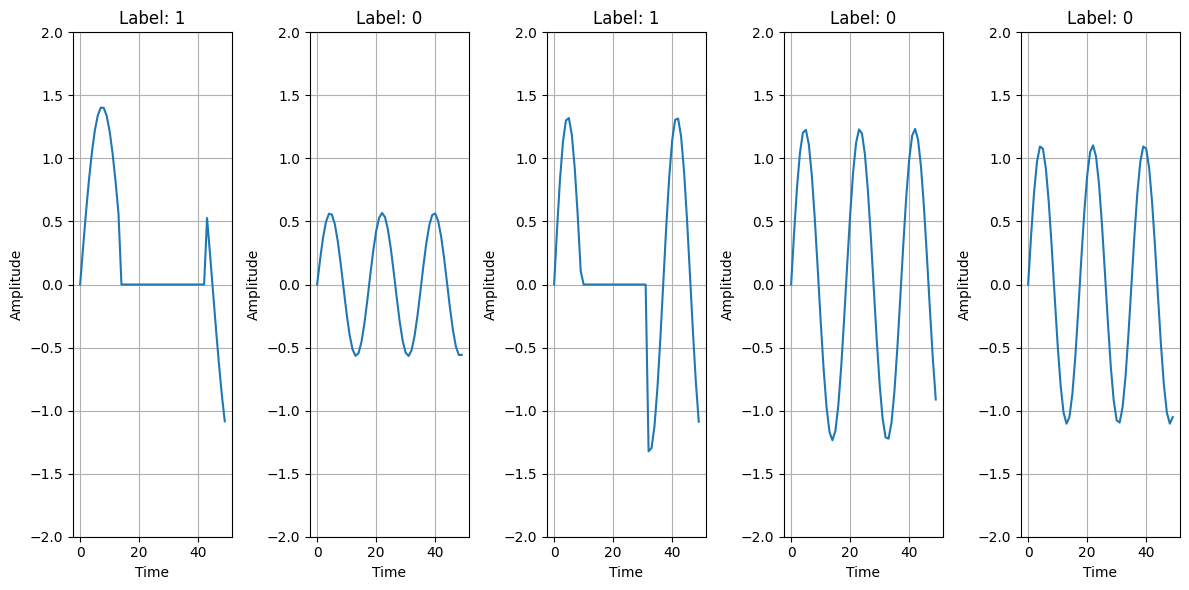

In [15]:
import matplotlib.pyplot as plt

def plot_sample_waves(X, Y, n=5):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.plot(X[i].squeeze(), label=f"Class {Y[i]}")
        plt.ylim(-2, 2)
        plt.title(f"Label: {Y[i]}")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.grid(True)
    plt.tight_layout()
    plt.show()

# 앞에서 생성한 데이터 시각화
plot_sample_waves(X, Y, n=5)


In [16]:
def create_decoder_input_and_target(X):
    """
    X: (num_samples, timesteps, d_model)
    returns:
        decoder_input: (num_samples, timesteps + 1, d_model)
        target:        (num_samples, timesteps + 1, d_model)
    """
    d_model = X.shape[2]
    batch_size = X.shape[0]
    timesteps = X.shape[1]

    # decoder_input: [0 vector] + X → shape: (batch, timesteps + 1, d_model)
    start_token = np.zeros((batch_size, 1, d_model), dtype=np.float32)
    decoder_input = np.concatenate([start_token, X], axis=1)

    # target: X + [0 vector] → shape: (batch, timesteps + 1, d_model)
    end_token = np.zeros((batch_size, 1, d_model), dtype=np.float32)
    target = np.concatenate([X, end_token], axis=1)

    return decoder_input, target

decoder_input_train, target_train = create_decoder_input_and_target(X_train)
decoder_input_test, target_test = create_decoder_input_and_target(X_test)
decoder_input_train.shape

(800, 51, 1)

In [17]:
input_shape = X.shape[1:]

model = build_transformer_model(
    input_shape=input_shape,
    key_dim=8,
    num_heads=2,
    ff_dim=64,
    num_encoder_blocks=2,
    num_decoder_blocks=1,
    dropout=0.1
)
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50, 1)]      0           []                               
                                                                                                  
 positional_encoding_5 (Positio  (None, 50, 1)       0           ['input_5[0][0]']                
 nalEncoding)                                                                                     
                                                                                                  
 layer_normalization_70 (LayerN  (None, 50, 1)       2           ['positional_encoding_5[0][0]']  
 ormalization)                                                                                    
                                                                                            

In [18]:
model.fit(
    [X_train, decoder_input_train],
    target_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/100
23/23 [==============================] - 8s 114ms/step - loss: 0.6901 - val_loss: 0.6602
Epoch 2/100
23/23 [==============================] - 2s 71ms/step - loss: 0.6381 - val_loss: 0.6148
Epoch 3/100
23/23 [==============================] - 2s 70ms/step - loss: 0.6005 - val_loss: 0.5820
Epoch 4/100
23/23 [==============================] - 2s 72ms/step - loss: 0.5708 - val_loss: 0.5557
Epoch 5/100
23/23 [==============================] - 2s 74ms/step - loss: 0.5451 - val_loss: 0.5324
Epoch 6/100
23/23 [==============================] - 2s 74ms/step - loss: 0.5240 - val_loss: 0.5115
Epoch 7/100
23/23 [==============================] - 2s 75ms/step - loss: 0.5036 - val_loss: 0.4920
Epoch 8/100
23/23 [==============================] - 2s 75ms/step - loss: 0.4849 - val_loss: 0.4739
Epoch 9/100
23/23 [==============================] - 2s 77ms/step - loss: 0.4668 - val_loss: 0.4568
Epoch 10/100
23/23 [==============================] - 2s 73ms/step - loss: 0.4500 - val_loss: 0.440

In [19]:
eval_result = model.evaluate([X_test, decoder_input_test], Y_test)
print("Test accuracy:", eval_result)


7/7 [==============================] - 1s 32ms/step - loss: 0.5745
Test accuracy: 0.5744931697845459
